# Experimenting with Data Processing

1. Helper functions to plot the chromagram/spectrogram

In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

def generate_cqt_chromagram(audio, sr=None, mono=True):
    #Load the audio file
    y, sr = librosa.load(audio, sr=sr, mono=mono)

    #Compute the CQT absolute amplitudes
    cqt = np.abs(librosa.cqt(y=y, sr=sr, hop_length=512, n_bins=7*12)) #7 octaves, 12 bins per octave
    cqt_db = librosa.amplitude_to_db(cqt, ref=np.max)

    #Compute the chromagram from the CQT
    chroma = librosa.feature.chroma_cqt(y=y, sr=sr, hop_length=512)

    return chroma, cqt_db, sr

def plot_cqt_chromagram(chroma, sr):
    plt.figure(figsize=(12, 4))
    librosa.display.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', vmin=0, vmax=1)
    plt.title('Chromagram')
    plt.colorbar()
    plt.tight_layout()
    plt.show()

def plot_cqt_spectrogram(cqt_db, sr):
    plt.figure(figsize=(12, 4)) #or 10, 4
    librosa.display.specshow(cqt_db, sr=sr, x_axis='time', y_axis='cqt_hz')
    plt.title('CQT')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


2. Prints out chroma and spectrograms. Chromagrams have clearer contrasts and are organized by semitones, making them more human-readable. We will proceed with chromagrams for further analysis for this reason.

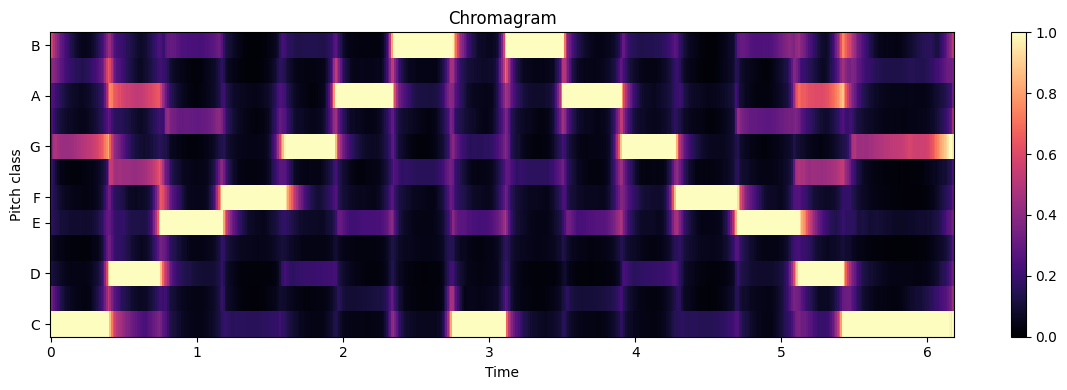

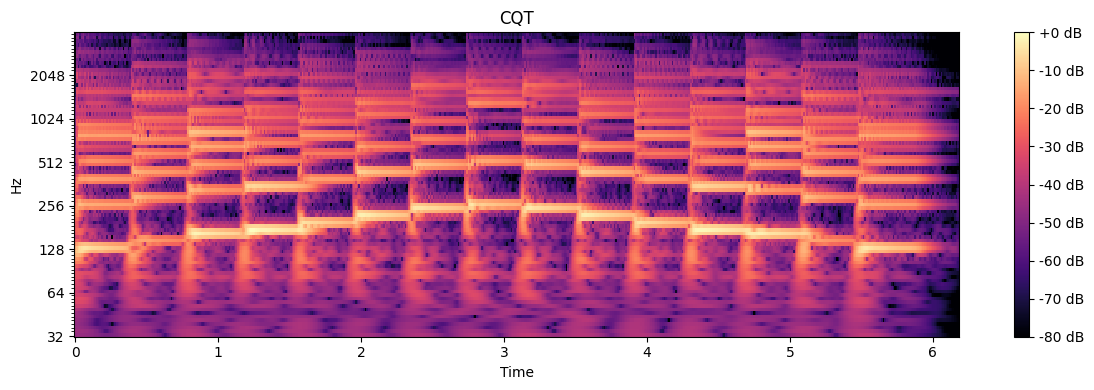

In [ ]:
# Build a path to the audio file relative to this script’s location
# script_dir = os.path.dirname(__file__)
# audio_path = os.path.join(script_dir, 'c-major-scale.wav')

audio_path = "/content/drive/MyDrive/c-major-scale.wav"
# Load an example audio file
#audio_path = "\src\c-major-scale.wav"
#y, sr = librosa.load(audio_path, sr=22050)

# Compute CQT spectrogram
chroma, cqt_db, sr = generate_cqt_chromagram(audio_path)

# Plot the CQT chromagram and spectrogram
plot_cqt_chromagram(chroma, sr)
plot_cqt_spectrogram(cqt_db, sr)


3. Convert chromagram into length-12 vector by recording the most dominant frequency in each time segment, forming a pitch class profile vector.

In [ ]:
chroma_shape = chroma.shape
PCP = np.zeros(12)
print(chroma_shape)
for i in range(chroma_shape[1]):
  PCP[np.argmax(chroma[:,i])] += 1

notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
present_notes = []
for i in range(12):
  print(notes[i], " intensity : ", PCP[i])
  if PCP[i] > 0:
    present_notes.append(notes[i])

print("Audio clip consists of ", present_notes)

(12, 533)
C  intensity :  130.0
C#  intensity :  0.0
D  intensity :  56.0
D#  intensity :  0.0
E  intensity :  74.0
F  intensity :  73.0
F#  intensity :  0.0
G  intensity :  63.0
G#  intensity :  0.0
A  intensity :  68.0
A#  intensity :  0.0
B  intensity :  69.0
Audio clip consists of  ['C', 'D', 'E', 'F', 'G', 'A', 'B']


4. Adjust this method to work for chords where multiple notes are played at the same time. Since we are classifying triads, we will extract the top three most prominent notes.

In [ ]:
#helper function to get N max elements from a list.
#If we want to expand to 4-note chords we can simply change the parameter
def Nmaxelements(arr, N):

  # Get indices of sorted elements
  sorted_indices = np.argsort(arr)

  # Return the indices of the three largest elements
  top_three_indices = sorted_indices[-3:]

  return top_three_indices.tolist()  # Convert to list for consistency

#helper function to process a single audio file
def process_audio(audio_path, n):
  chroma, cqt_db, sr = generate_cqt_chromagram(audio_path)
  plot_cqt_chromagram(chroma, sr)
  plot_cqt_spectrogram(cqt_db, sr)
  PCP = np.zeros(12)
  cleaned_triad = np.zeros(12)

  chroma_shape = chroma.shape

  for i in range(chroma.shape[1]):
    for j in range(12):
      PCP[j] += chroma[j, i]

  triad_indices = Nmaxelements(PCP, 3)

  return PCP, triad_indices

def print_chord(PCP, triad_indices):
  present_notes = []
  print(triad_indices)
  notes = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
  for i in range(12):
    print(notes[i], " intensity : ", PCP[i])

  for i in triad_indices:
    present_notes.append(notes[i])


  print("Audio clip consists of ", present_notes)

Using the process outlined above we can easily extract the most prominent notes in each of our audio files. Testing with a diminished chord

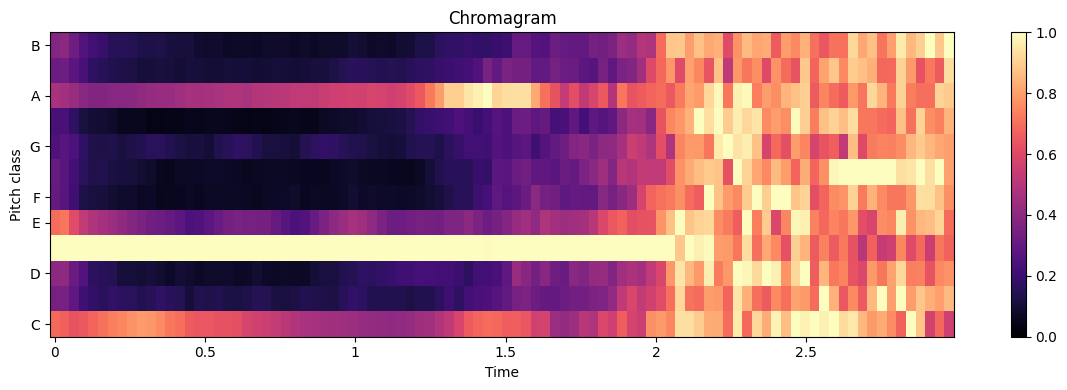

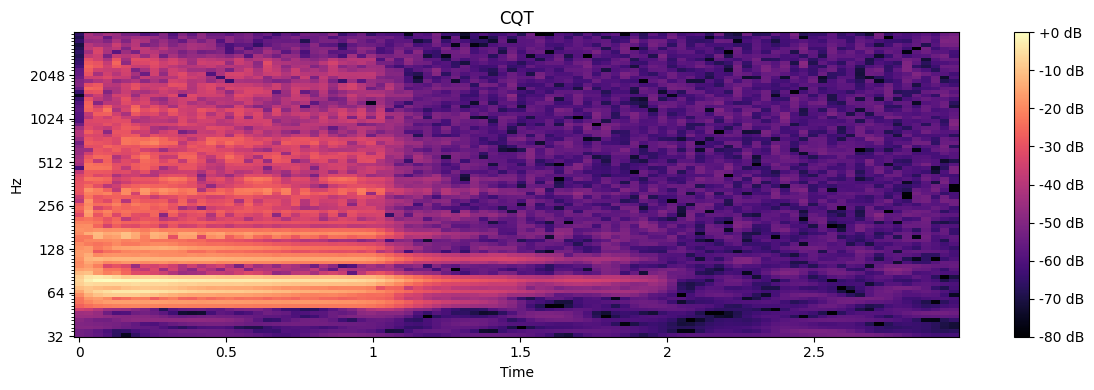

[9, 0, 3]
C  intensity :  62.72505921125412
C#  intensity :  38.58573453128338
D  intensity :  38.63059426099062
D#  intensity :  86.32447218894958
E  intensity :  50.47993828356266
F  intensity :  36.040091667324305
F#  intensity :  37.62071272730827
G  intensity :  36.33649552613497
G#  intensity :  35.759285274893045
A  intensity :  61.828992158174515
A#  intensity :  36.12093721330166
B  intensity :  36.92633794248104
Audio clip consists of  ['A', 'C', 'D#']


In [ ]:
PCP_dim, dim_indices = process_audio('/content/drive/MyDrive/Split_Chords_Dataset/train/diminished/A-1-diminished-chord-0_noise2.wav', 3)
print_chord(PCP_dim, dim_indices)


The chord "C, D#, A" is in fact a diminished chord, so our processing works. It seems there is noise near the end affecting the reading with a strong signal in A# and G. After listening to the audio files it sounds like the chord ends a little before 2 seconds, so we will trim everything down to 2 seconds for clarity. We also don't need to print the chromagram and spectrogram every single time, so we will add an option to toggle that on and off.

/usr/local/lib/python3.11/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=512 is too large for input signal of length=500
  warnings.warn(


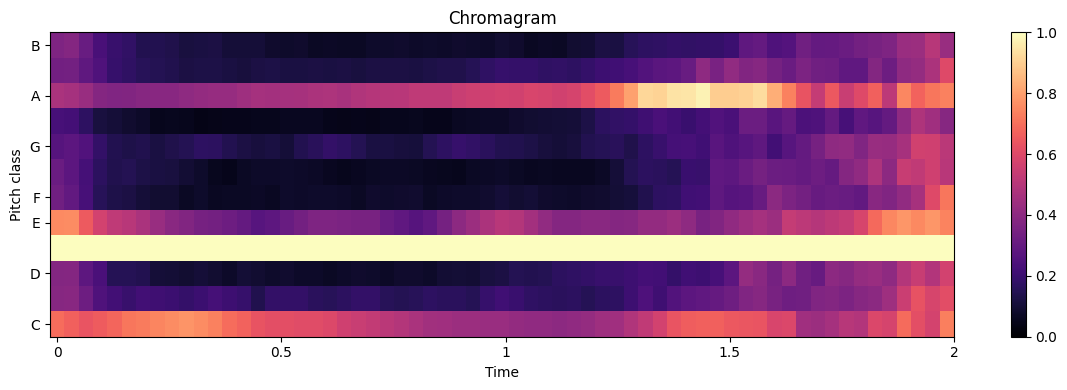

[0, 9, 3]
C  intensity :  36.0861314535141
C#  intensity :  16.35723105072975
D  intensity :  13.362092591822147
D#  intensity :  63.0
E  intensity :  28.493957668542862
F  intensity :  11.454664446413517
F#  intensity :  11.348117746412754
G  intensity :  13.526514157652855
G#  intensity :  9.843155793845654
A  intensity :  37.35573586821556
A#  intensity :  14.627071999013424
B  intensity :  11.43368923664093
Audio clip consists of  ['C', 'A', 'D#']


In [ ]:
def process_audio_file(audio_path, n, plot):
  #Load the audio file
  y, sr = librosa.load(audio_path, sr=None, mono=True)
  # Trim the audio to 2 seconds
  duration_seconds = 2.0  # Desired duration in seconds
  y = y[:int(duration_seconds * sr)]  # Trim audio data

  #Compute the CQT absolute amplitudes
  # cqt = np.abs(librosa.cqt(y=yt, sr=sr, hop_length=512, n_bins=7*12)) #7 octaves, 12 bins per octave
  # cqt_db = librosa.amplitude_to_db(cqt, ref=np.max)
  chroma = librosa.feature.chroma_cqt(y=y, sr=sr, hop_length=512)
  PCP = np.zeros(12)

  if plot:
    plot_cqt_chromagram(chroma, sr)

  chroma_shape = chroma.shape

  for i in range(chroma.shape[1]):
    for j in range(12):
      PCP[j] += chroma[j, i]

  triad_indices = Nmaxelements(PCP, 3)

  return PCP, triad_indices

PCP_dim_2, present_notes_dim_2 = process_audio_file('/content/drive/MyDrive/Split_Chords_Dataset/train/diminished/A-1-diminished-chord-0_noise2.wav',
                                                    n = 3, plot=True)
print_chord(PCP_dim_2, present_notes_dim_2)


# Load Datasets

We need to process all our data this way for our model. Huge thank you to Nathan and Chrysanthi for collecting and organizing the labeled audio files. In total our dataset is 6120 files, 1530 per chord class. They have been split into 80% training, 10% validation, and 10% testing.

In [ ]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

# Define dataset paths
DATASET_PATH = '/content/drive/My Drive/Split_Chords_Dataset/'  # Update this path
TRAIN_PATH = os.path.join(DATASET_PATH, 'train')
VAL_PATH = os.path.join(DATASET_PATH, 'val')
TEST_PATH = os.path.join(DATASET_PATH, 'test')

# Placeholder for processed data
def load_dataset(dataset_path):
    data = []

    for class_label in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_label)

        if not os.path.isdir(class_path):
            continue  # Skip non-folder files

        audio_files = os.listdir(class_path)
        print(f"Loading {len(audio_files)} files from class '{class_label}'")

        for audio_file in tqdm(audio_files, desc=f"Processing {class_label}"):
            audio_path = os.path.join(class_path, audio_file)

            # Process audio file
            PCP_vec = process_audio_file(audio_path, 3, False)  # Returns PCP
            data.append((PCP_vec, class_label))

    print("\nProcessed ", len(data), " files in ", dataset_path)
    return np.array(data, dtype=object)

# Load datasets
train_data = load_dataset(TRAIN_PATH)
val_data = load_dataset(VAL_PATH)
test_data = load_dataset(TEST_PATH)
print("\nDatasets Loaded! \n")

# Convert to Pandas DataFrame for easier handling
columns = ['pcp', 'label']
df_train = pd.DataFrame(train_data, columns=columns)
df_val = pd.DataFrame(val_data, columns=columns)
df_test = pd.DataFrame(test_data, columns=columns)
print("\nConverted to Pandas DataFrames \n")

# Save datasets
output_dir = '/content/drive/My Drive/Chord_Pandas_Dataset/'
os.makedirs(output_dir, exist_ok=True)

df_train.to_pickle(os.path.join(output_dir, 'train.pkl'))
df_val.to_pickle(os.path.join(output_dir, 'val.pkl'))
df_test.to_pickle(os.path.join(output_dir, 'test.pkl'))

print("Datasets loaded and saved in", output_dir)


AttributeError: partially initialized module 'pandas' has no attribute '_pandas_parser_CAPI' (most likely due to a circular import)

Transform the pandas dataframes to pytorch data loaders

In [ ]:
#create dataloaders for training
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder

# Encode labels as integers
label_encoder = LabelEncoder()
df_train["label"] = label_encoder.fit_transform(df_train["label"])
df_val["label"] = label_encoder.transform(df_val["label"])
df_test["label"] = label_encoder.transform(df_test["label"])

class AudioDataset(Dataset):
    def __init__(self, df):
        self.features = torch.tensor(np.vstack([np.array(x[0]) for x in df["pcp"]]), dtype=torch.float32)
        self.labels = torch.tensor(df["label"].values, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create datasets
train_dataset = AudioDataset(df_train)
val_dataset = AudioDataset(df_val)
test_dataset = AudioDataset(df_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

NameError: name 'df_train' is not defined

In [ ]:
#create dataloaders for training
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import pandas as pd
import numpy as np
import os

# Define paths to stored pickle files
DATASET_PATH = "/content/drive/My Drive/Chord_Pandas_Dataset/"
train_pkl = os.path.join(DATASET_PATH, "train.pkl")
val_pkl = os.path.join(DATASET_PATH, "val.pkl")
test_pkl = os.path.join(DATASET_PATH, "test.pkl")

# Load datasets from pickle files
df_train = pd.read_pickle(train_pkl)
df_val = pd.read_pickle(val_pkl)
df_test = pd.read_pickle(test_pkl)

# Encode labels into integers
label_encoder = LabelEncoder()
df_train["label"] = label_encoder.fit_transform(df_train["label"])
df_val["label"] = label_encoder.transform(df_val["label"])
df_test["label"] = label_encoder.transform(df_test["label"])

class AudioDataset(Dataset):
    def __init__(self, df):
        # Extract PCP vectors and convert to NumPy array
        pcp_vectors = [x[0] for x in df["pcp"]]  # Access the first element (PCP vector) of each tuple
        self.features = torch.tensor(np.vstack(pcp_vectors), dtype=torch.float32)
        self.labels = torch.tensor(df["label"].values, dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Create DataLoaders with hyperparameter batch size
train_dataset = AudioDataset(df_train)
val_dataset = AudioDataset(df_val)
test_dataset = AudioDataset(df_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


# Base Model
We will use a simple ANN to classify our data. It will have 12 inputs, 4 outputs (0 = augmented, 1 = diminished, 2 = major, 3 = minor), with a hidden layer.

In [ ]:
#3 layer ANN
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim

class model(nn.Module):
  def __init__(self):
    super(model, self).__init__()
    self.layer1 = nn.Linear(12, 16, bias=True)
    self.layer2 = nn.Linear(16, 8, bias=True)
    self.layer3 = nn.Linear(8, 4, bias=True)

  def forward(self, x):
    x = F.relu(self.layer1(x))
    x = F.relu(self.layer2(x))
    x = F.softmax(self.layer3(x), dim=1)
    return x

Now we train the model!

In [ ]:
import time

def train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  model.to(device)
  start_time = time.time()
  train_acc_history = np.zeros(num_epochs)  # Initialize empty list for train acc
  val_acc_history = np.zeros(num_epochs)
  train_loss_history = np.zeros(num_epochs)
  val_loss_history = np.zeros(num_epochs)

  for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0

    for features, labels in train_loader:
      features, labels = features.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(features)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      train_loss += loss.item()
      train_correct += (outputs.argmax(1) == labels).sum().item()

    train_loss_history[epoch] = train_loss/ len(train_loader)
    train_acc_history[epoch] = train_correct / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    val_correct = 0

    with torch.no_grad():
      for features, labels in val_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        loss = criterion(outputs, labels)

        val_loss += loss.item()
        val_correct += (outputs.argmax(1) == labels).sum().item()

    val_loss_history[epoch] = val_loss / len(val_loader)
    val_acc_history[epoch] = val_correct / len(val_loader.dataset)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss_history[epoch]:.4f}, Train Acc: {train_acc_history[epoch]:.4f}, || Val Loss: {val_loss_history[epoch]:.4f}, Val Acc: {val_acc_history[epoch]:.4f}")

  print("Finished Training")
  end_time = time.time()
  print(f"Training time: {end_time - start_time:.2f} seconds")

  #save training files
  path = "/content/drive/My Drive/Chord_Model/base_model/"
  np.savetxt("{}train_acc.csv".format(path), train_acc_history)
  np.savetxt("{}val_acc.csv".format(path), val_acc_history)
  np.savetxt("{}train_loss.csv".format(path), train_loss_history)
  np.savetxt("{}val_loss.csv".format(path), val_loss_history)


In [ ]:
base_model = model()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(base_model.parameters(), lr=0.001)
num_epochs = 100

train_model(base_model, train_loader, val_loader, num_epochs, criterion, optimizer)


Epoch 1/100, Train Loss: 1.3931, Train Acc: 0.2545, || Val Loss: 1.3628, Val Acc: 0.2941
Epoch 2/100, Train Loss: 1.3639, Train Acc: 0.2872, || Val Loss: 1.3454, Val Acc: 0.3186
Epoch 3/100, Train Loss: 1.3430, Train Acc: 0.3407, || Val Loss: 1.3208, Val Acc: 0.3775
Epoch 4/100, Train Loss: 1.3155, Train Acc: 0.3828, || Val Loss: 1.2743, Val Acc: 0.4281
Epoch 5/100, Train Loss: 1.2590, Train Acc: 0.4540, || Val Loss: 1.2174, Val Acc: 0.4804
Epoch 6/100, Train Loss: 1.2304, Train Acc: 0.4843, || Val Loss: 1.2017, Val Acc: 0.5147
Epoch 7/100, Train Loss: 1.2146, Train Acc: 0.5045, || Val Loss: 1.1917, Val Acc: 0.5163
Epoch 8/100, Train Loss: 1.2042, Train Acc: 0.5102, || Val Loss: 1.1788, Val Acc: 0.5327
Epoch 9/100, Train Loss: 1.1925, Train Acc: 0.5337, || Val Loss: 1.1582, Val Acc: 0.5637
Epoch 10/100, Train Loss: 1.1868, Train Acc: 0.5413, || Val Loss: 1.1624, Val Acc: 0.5686
Epoch 11/100, Train Loss: 1.1816, Train Acc: 0.5488, || Val Loss: 1.1465, Val Acc: 0.5850
Epoch 12/100, Train

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


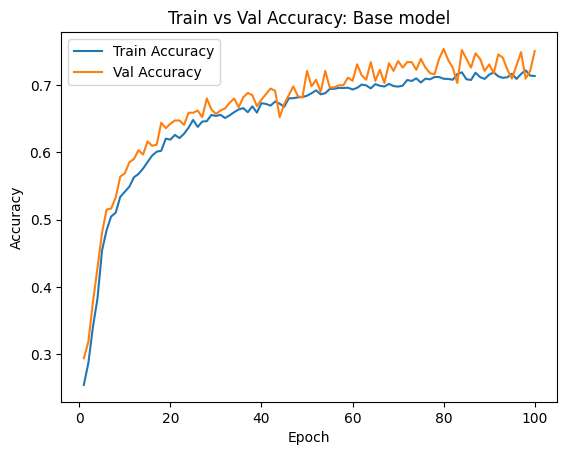

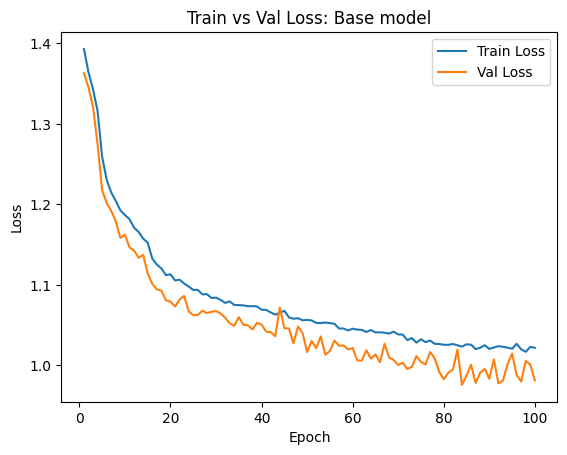

In [ ]:
#plot train/val curve
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
drive.mount('/content/drive')
path = "/content/drive/My Drive/Chord_Model/base_model/"

train_acc = np.loadtxt("{}train_acc.csv".format(path))
val_acc = np.loadtxt("{}val_acc.csv".format(path))
train_loss = np.loadtxt("{}train_loss.csv".format(path))
val_loss = np.loadtxt("{}val_loss.csv".format(path))

plt.title("Train vs Val Accuracy: Base model")
n = len(train_acc)
plt.plot(range(1, n+1), train_acc, label = "Train Accuracy")
plt.plot(range(1, n+1), val_acc, label = "Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.title("Train vs Val Loss: Base model")
plt.plot(range(1, n+1), train_loss, label = "Train Loss")
plt.plot(range(1, n+1), val_loss, label = "Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

Evaluating our base model on the test dataset

In [ ]:
base_model.eval()
test_loss = 0.0
test_correct = 0
with torch.no_grad():
  for i, data in val_loader:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    features, labels = i.to(device), data.to(device)
    outputs = base_model(features)
    loss = criterion(outputs, labels)
    test_loss += loss.item()
    test_correct += (outputs.argmax(1) == labels).sum().item()

  test_loss /= len(test_loader)
  test_acc = test_correct / len(test_loader.dataset)

  print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
#

Test Loss: 0.9684, Test Acc: 0.7533


In [ ]:
# Confusion matrix:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, data_loader, dataset, label_encoder):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model.eval()
    all_preds = []
    all_labels = []

    misclassified_examples = []

    with torch.no_grad():
        for features, labels in data_loader:
            features, labels = features.to(device), labels.to(device)
            outputs = model(features)
            _, preds = torch.max(outputs, 1)  # Get predicted labels

            all_preds.extend(preds.cpu().numpy())  # Move to CPU and convert to NumPy
            all_labels.extend(labels.cpu().numpy())

            for i in range(len(preds)):
                if preds[i] != labels[i]:
                    misclassified_examples.append((features[i], labels[i], preds[i]))

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    chord_labels = list(label_encoder.classes_)

    # Plot confusion matrix using Seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Reds",
                xticklabels=chord_labels, yticklabels=chord_labels)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    return misclassified_examples

def test_model(model, test_loader, criterion):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  model.eval()
  test_loss = 0.0
  test_correct = 0
  total = 0

  with torch.no_grad():
      for features, labels in test_loader:
          features, labels = features.to(device), labels.to(device)
          outputs = model(features)
          #calculating loss
          loss = criterion(outputs, labels)
          test_loss += loss.item() * features.size(0)
          test_correct += (outputs.argmax(dim=1) == labels).sum().item()
          total += features.size(0)

  avg_loss = test_loss / total
  accuracy = test_correct / total

  print(f"Test Loss: {avg_loss:.4f}, Test Accuracy: {accuracy:.4f}")



Test Loss: 1.0248, Test Accuracy: 0.7092


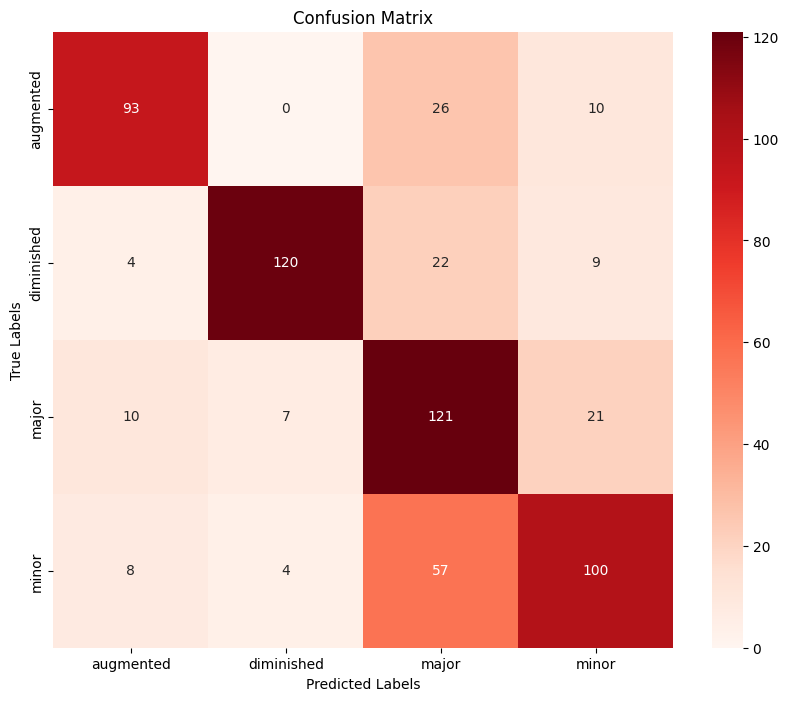

178 misclassified examples out of  612
Label: 0, Chord: augmented, length: 129
Label: 1, Chord: diminished, length: 155
Label: 2, Chord: major, length: 159
Label: 3, Chord: minor, length: 169


In [ ]:
test_model(base_model, test_loader, criterion)
misclassified_examples_2 = plot_confusion_matrix(base_model, test_loader, test_dataset, label_encoder) # Pass label_encoder
print(len(misclassified_examples_2), "misclassified examples out of ", len(test_dataset))

for idx, label in enumerate(label_encoder.classes_):
    print(f"Label: {idx}, Chord: {label}, length: {len(df_test[df_test['label'] == idx])}") # Access original DataFrame for length
